# Random chains

## Ideal chain

Consider a chain composed of $N+1$ monomers, linked by a rigid bond of fixed length $a$. This chain, subject to thermal fluctuations, constitutes the simplest model of polymers that we can treat computationally.

The assumptions are therefore:
- $N+1$ monomers and hence $N$ segments connectign them
- constant bond length $|\vec{a}_i|=a$
- independent random orientations of the $N$ segments, with 
    - mean $\langle \vec{a}_i\rangle =\vec{0}$
    - variance $\langle \vec{a}_i\vec{a}_j\rangle = a^2\delta_{ij}$


Let us create one.

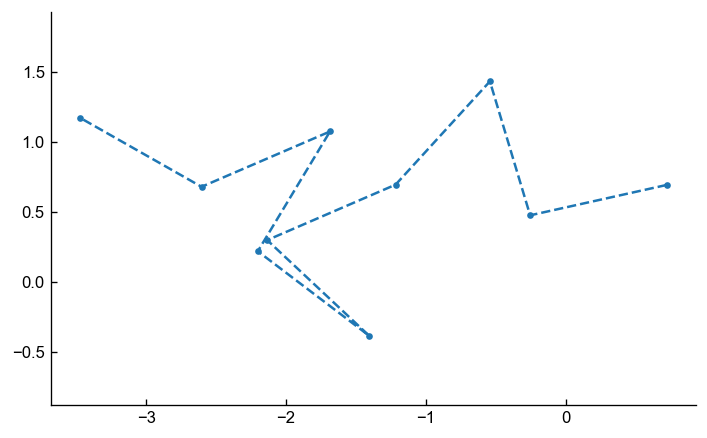

In [2]:
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng()

def random_orientations(N,dim=2):
    """Generate N vectors on the surface of a d-dimensional unit sphere (Muller 1959, Marsaglia 1972)."""
    pnt = rng.normal(0,1,(N,2))
    return pnt/np.linalg.norm(pnt, axis=1)[:,np.newaxis]

def create_ideal_chain(N=10,a=1):
    """Create an ideal chain of N monomers."""
    # draw N vectors on the unit circle and scale
    vectors_a = a*random_orientations(N,dim=2)
    chain = np.cumsum(vectors_a, axis=0)
    return chain

chain = create_ideal_chain(N=10)
plt.plot(chain[:,0], chain[:,1], '.--')
plt.axis('equal');


We can generate ensembles of chains.

In [3]:
def generate_ideal_chain_ensemble(N=100, nchains = 10000):
    chains = [create_ideal_chain(N=N) for i in range(nchains)]
    return chains

### End-to-end vector

The beginning and the end of the chain define a **vector** $$\vec{R}=\vec{r}_{N}-\vec{r}_0$$ which has specific statistical properties.

#### Components
The vector converges to the **null vector** for long enough chains $\langle\vec{R}\rangle=\left\langle\sum_{i=1}^N \vec{a}_i\right\rangle=\sum_{i=1}^N\left\langle\vec{a}_i\right\rangle=\overrightarrow{0}$


In [4]:
# end-to-end vectors
N = 100
end_to_ends = np.array([c[-1]-c[0] for c in generate_ideal_chain_ensemble(N=N,nchains=10000)])
print(N,np.mean(end_to_ends, axis=0))


100 [-0.01235579  0.09497743]


#### Average squared distance

The average **square of the distance** grows like $N$, $$\left\langle|\bar{R}|^2\right\rangle=\left\langle\left(\sum_{i=1}^N \vec{a}_i\right) \cdot\left(\sum_{i=1}^M \stackrel{\rightharpoonup}{a}_j\right)\right\rangle=N a^2+\sum_{i=1}^N \sum_{j=1}^N\langle\left\langle\vec{a}_i \cdot \vec{a}_j\right\rangle=a^2 N \sim N$$

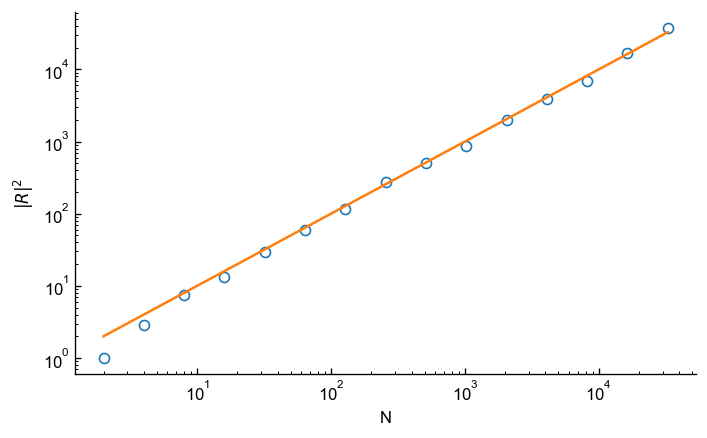

In [5]:

Ns = 2**np.arange(1,16)
norms = []
for N in Ns:
    chains = np.array(generate_ideal_chain_ensemble(N=N,nchains=100))
    end_to_ends = chains[:,-1,:]-chains[:,0,:] 
    norms.append((np.linalg.norm(end_to_ends, axis=1)**2).mean())

plt.loglog(Ns,norms, 'o', mfc="None")
plt.loglog(Ns,Ns)
plt.xlabel('N')
plt.ylabel(r'$|R|^2$');

Clearly, such scaling is linked to the behaviour of a random walker and its mean squared displacement, as seen in the previous [Random walk](rw) lesson.


### Distribution

As the chains are anlogous to random walks, the distribution of the end-to-end vector eventually converge to a Gaussian distirbution for sufficiently large $N$

In three dimension, in particular, the convergence leads to

$$p(|\vec{R}|) \approx \frac{1}{\left(2 \pi a^2 / 3 N\right)^{3 / 2}} \exp \left(-\frac{3}{2 a^2 N}|\vec{R}|^2\right)$$

Again, this can be easily verified numericlaly.

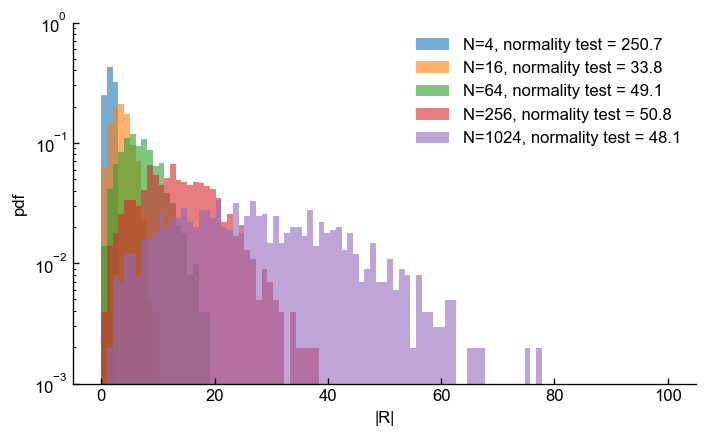

In [36]:
from scipy.stats import normaltest
Ns = 2**np.arange(2,12,2)
norms = []
bins = np.linspace(0,100,100)
for N in Ns:
    chains = np.array(generate_ideal_chain_ensemble(N=N,nchains=1000))
    end_to_ends = chains[:,-1,:]-chains[:,0,:] 
    norms = np.linalg.norm(end_to_ends, axis=1)
    
    plt.hist(norms, bins=bins,density=True, label=f"N={N}, normality test = {normaltest(norms)[0]:.1f}", alpha=0.6)

plt.legend()

plt.yscale('log')
plt.ylim(0.001,1)
plt.xlabel("|R|"), plt.ylabel('pdf')
# 
pass

Notice that the approximation with a Gaussian distribution is valid only around the peak of the probability and for large $N$. The plot also illutrates the evolution of a nomality test based on skewness and kurtosis (the lower the value, the more Gaussian the distribution).


### Free energy

We can analyse the distribution to get a more physical picture.

For a given end-to-end vector $\vec{R}$ we have that the number of conformations of the chain scales like

$$\Omega(\bar{R}) \sim \exp \left(-\frac{3|\vec{R}|^2}{2 a^2 N}\right)$$

We can then associate an **entropy** to it using [Boltzmann's famous formula](https://en.wikipedia.org/wiki/Boltzmann%27s_entropy_formula#/media/File:Zentralfriedhof_Vienna_-_Boltzmann.JPG)[^1]: The equation is actually due to Planck (see for example  Planck, M “On the Theory of the Energy Distribution Law of the Normal Spectrum” (1900) English translation from Haar, D. The Old Quantum Theory (1967) p. 83 [link](https://www.informationphilosopher.com/solutions/scientists/planck/Planck_1900b.pdf)).

$$S(\vec{R})=k_B \ln \Omega(\vec{R})=-\frac{3 k_B|\vec{R}|^2}{2 a^2 N}+{\rm const.}$$

Since the chain is ideal, there is no energetic contribution to the free energy, which therefore is simply


$$ F = U - T S= \frac{3 k_B T|\vec{R}|^2}{2 a^2 N}+{\rm const.}$$

Notice that this takes a **quadratic** form in the magnitude of the end-to-end vector, justifying its identification as **entropic elasticity**.

## Gaussian chain

The fixed length of the ideal chain is quite restrictive. A more *flexible* model is obtained if we admit that the various segments are distributed in length and orientation.

We take again

- N+1 monomers
- successive monomers are connected by vectors $\vec{b}_i$, which are independent random vectors, whose magnitude follows the normal distribution

$$p\left(\vec{b}_i\right)=\frac{1}{\left(2 \pi b^2 / 3\right)^{3 / 2}} \exp \left(-\frac{3\left|\vec{b}_i\right|^2}{2 b^2}\right)$$

with zero mean and standard deviation $b$.


Since $\vec{R}_{i+1}-\vec{R}_i=\vec{b}_i$, the joint distribution for the $N$ segments corrsponds then to the distribution of the $N+1$ monomer posisitons:

$$p\left(\vec{R}_1, \cdots, \widetilde{R}_{\pi+1}\right)=\left(\frac{3}{2 \pi b^2}\right)^{\frac{3 N}{2}} \exp \left(-\sum_{i=1}^N \frac{3}{2 b^2}\left|\bar{R}_{i+1}-\bar{R}_i\right|^2\right)$$

Since the variance of the sum of normal distributed random variables is the the sum of the variances, the end-to-end vector $\vec{R}=\vec{R}_{N+1}-\vec{R}_{1}$ has variance

$$ \left\langle\left|\vec{R}^{\prime}\right|^2\right\rangle=b^2 N$$